<a href="https://colab.research.google.com/github/crystal-zhu/Sitcom_Success_Factors-CSDS_312/blob/main/Sitcom_Success_Factors_b99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from textblob import TextBlob
import os.path
import gensim
from gensim import corpora
from gensim.models import LsiModel
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer


nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download("averaged_perceptron_tagger")

from nltk.tokenize import word_tokenize
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sb
import numpy as np
from textblob import TextBlob
import re

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("/content/drive/Shareddrives/CSDS 312 Final Project/b99_data/B99_Reviews/brooklyn99_episodes.csv") as d:
  ep_data = pd.read_csv(d)

with open("/content/drive/Shareddrives/CSDS 312 Final Project/b99_data/B99_Reviews/brooklyn99_imdb.csv") as e:
  imdb_data = pd.read_csv(e)



In [ ]:
print(ep_data)

     season  episode_num_in_season  episode_num_overall              title  \
0         1                      1                    1              Pilot   
1         1                      2                    2         The Tagger   
2         1                      3                    3          The Slump   
3         1                      4                    4          M.E. Time   
4         1                      5                    5        The Vulture   
..      ...                    ...                  ...                ...   
148       8                      6                  149         The Set Up   
149       8                      7                  150     Game of Boyles   
150       8                      8                  151            Renewal   
151       8                      9                  152  The Last Day Pt 1   
152       8                     10                  153  The Last Day Pt 2   

                        directed_by                            

<Axes: xlabel='episode_num_in_season', ylabel='season'>

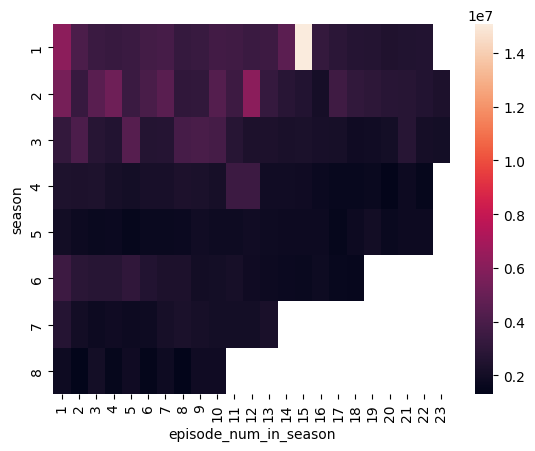

In [ ]:
ep_data['us_viewers'] = pd.to_numeric(ep_data['us_viewers'], errors = 'coerce')

views_heatmap = ep_data.pivot_table(index='season', columns='episode_num_in_season', values='us_viewers', aggfunc='mean')
sns.heatmap(views_heatmap)

In [ ]:
print(imdb_data)

     season  episode_num              title original_air_date  imdb_rating  \
0         1            1              Pilot      17 Sep. 2013          7.8   
1         1            2         The Tagger      24 Sep. 2013          7.5   
2         1            3          The Slump       1 Oct. 2013          7.6   
3         1            4          M.E. Time       8 Oct. 2013          7.7   
4         1            5        The Vulture      15 Oct. 2013          8.0   
..      ...          ...                ...               ...          ...   
148       8            6         The Set Up      26 Aug. 2021          6.8   
149       8            7     Game of Boyles       2 Sep. 2021          8.1   
150       8            8            Renewal       2 Sep. 2021          8.2   
151       8            9  The Last Day Pt 1      16 Sep. 2021          9.4   
152       8           10  The Last Day Pt 2      16 Sep. 2021          9.6   

     total_votes                                               

<Axes: xlabel='episode_num', ylabel='season'>

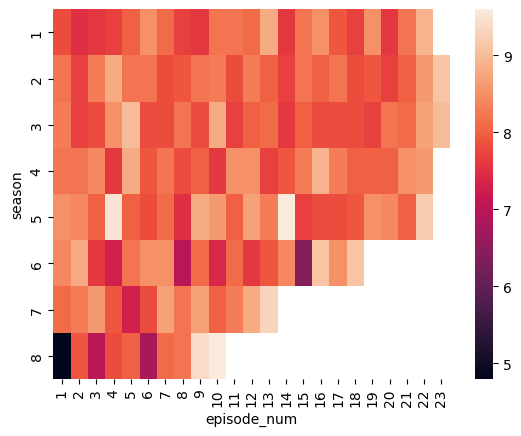

In [ ]:
imdb_data['imdb_rating'] = pd.to_numeric(imdb_data['imdb_rating'], errors = 'coerce')

imdb_heatmap = imdb_data.pivot_table(index='season', columns='episode_num', values='imdb_rating', aggfunc='mean')
sns.heatmap(imdb_heatmap)


<Axes: xlabel='episode_num', ylabel='season'>

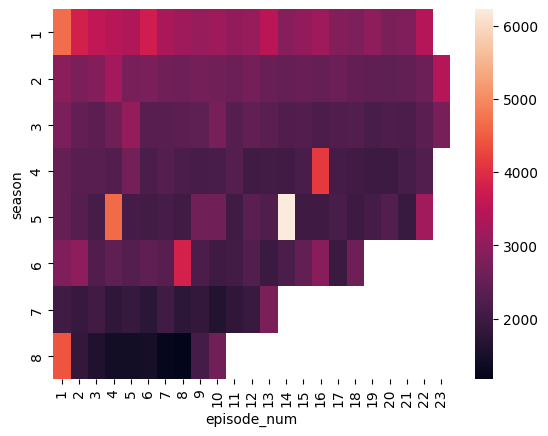

In [ ]:
imdb_data['total_votes'] = pd.to_numeric(imdb_data['total_votes'], errors = 'coerce')

imdb_heatmap2 = imdb_data.pivot_table(index='season', columns='episode_num', values='total_votes', aggfunc='mean')
sns.heatmap(imdb_heatmap2)

# Data Cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load the CSV file into a DataFrame
with open("/content/drive/Shareddrives/CSDS 312 Final Project/b99_data/B99_Script/B99(S4-8).csv") as d:
  df = pd.read_csv(d)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

df.head()

,B99 Transcripts,Unnamed: 1
0,08x10 - The Last Day (2),"Previously on ""Brooklyn Nine-Nine""... \n \nJa..."
1,08x09 - The Last Day (1),Terry loves waking up. \n \nTerry loves wakin...
2,08x08 - Renewal,"Holt: Lastly, on a personal note, \n \nas man..."
3,08x07 - Game of Boyles,"Mel: Good morning, Cousin Tommy. I love you. ..."
4,08x06 - The Set Up,"Holt: Attention, everyone,\na b*mb was just fo..."


In [ ]:

# Split the 'episode' column into 'season', 'episode', and 'title' columns

df[['season_episode', 'title']] = df['B99 Transcripts'].str.split(' - ', expand=True)
df[['season', 'episode']] = df['season_episode'].str.split('x', expand=True)

# Drop the original 'episode' and 'season_episode' columns
df.drop(columns=['B99 Transcripts', 'season_episode'], inplace=True)
df.rename(columns={'Unnamed: 1': 'script'}, inplace=True)
df = df[['season', 'episode', 'title', 'script']]

df.head()

,season,episode,title,script
0,08,10,The Last Day (2),"Previously on ""Brooklyn Nine-Nine""... \n \nJa..."
1,08,09,The Last Day (1),Terry loves waking up. \n \nTerry loves wakin...
2,08,08,Renewal,"Holt: Lastly, on a personal note, \n \nas man..."
3,08,07,Game of Boyles,"Mel: Good morning, Cousin Tommy. I love you. ..."
4,08,06,The Set Up,"Holt: Attention, everyone,\na b*mb was just fo..."


In [ ]:
df = df.dropna(subset=['script'])
df['script'] = df['script'].str.split('\n')
df = df.explode('script')
df = df[df['script'].str.contains(':')]
df = df.sort_values(by=['season', 'episode'])
df['script'] = df['script'].str.strip()
df[['character', 'dialogue','unt','unt1']] = df['script'].str.split(': ', expand=True)
df.drop(columns=['script','unt', 'unt1'], inplace=True)
df
# Split the script column into two columns based on the colon separator
# df[['character', 'dialogue']] = df['script'].str.split(': ', exCharlesd=True)


,season,episode,title,character,dialogue
77,04,07,Mr. Santiago,The question is,Who here does the best impression of Captain R...
77,04,07,Mr. Santiago,Everyone will perform the same scenario,Captain Holt eating a marshmallow for the very...
77,04,07,Mr. Santiago,My advice,don't be overconfident.
77,04,07,Mr. Santiago,Just a couple of factoids about Victor,"He's an ex-cop, 65 years old, married for 36 y..."
77,04,07,Mr. Santiago,What do you guys like better,"classic bishop hat fold or crown fold? Now, th..."
...,...,...,...,...,...
0,08,10,The Last Day (2),Rosa,Me too.
0,08,10,The Last Day (2),Gina,As am I.
0,08,10,The Last Day (2),Jake,"That's right, Terry,"
0,08,10,The Last Day (2),Terry,What I say is...


In [ ]:
drop = list(range(69, 77))
df.drop(index=drop, inplace=True)

In [ ]:
df.to_csv('/content/drive/Shareddrives/CSDS 312 Final Project/b99_data/B99_Script/B99(S4-8)_updated.csv', index=False)

In [ ]:
with open("/content/drive/Shareddrives/CSDS 312 Final Project/b99_data/B99_Script/b99_s1-4_updated.csv") as d:
  dfn = pd.read_csv(d, index_col = 2)
dfn = dfn.drop(dfn.index[0])
dfn = dfn.rename(columns={'Unnamed: 0': 'season', 'Unnamed: 1': 'episode','Unnamed: 3': 'title','seasons_1234(updated)': 'character','Unnamed: 5': 'dialogue' })
dfn.head()


,season,episode,title,character,dialogue
1,1,1,Pilot,JAKE,This job is eating me alive. I can't breathe ...
1,1,1,Pilot,AMY,"Hey! What are you doing, weirdo?"
1,1,1,Pilot,JAKE,I'm doing the best speech from Donnie Brasco....
1,1,1,Pilot,AMY,"Get it together, man. Okay?"
1,1,1,Pilot,AMY,So the store was hit about two hours ago. The...


In [ ]:
with open("/content/drive/Shareddrives/CSDS 312 Final Project/b99_data/B99_Script/B99(S4-8)_updated2.csv") as d:
  df = pd.read_csv(d)

dfn.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
b99_script = pd.concat([dfn, df], ignore_index=True)

b99_script


,season,episode,title,character,dialogue
0,1,1,Pilot,JAKE,This job is eating me alive. I can't breathe ...
1,1,1,Pilot,AMY,"Hey! What are you doing, weirdo?"
2,1,1,Pilot,JAKE,I'm doing the best speech from Donnie Brasco....
3,1,1,Pilot,AMY,"Get it together, man. Okay?"
4,1,1,Pilot,AMY,So the store was hit about two hours ago. The...
...,...,...,...,...,...
17524,8,10,The Last Day (2),Rosa,Me too.
17525,8,10,The Last Day (2),Gina,As am I.
17526,8,10,The Last Day (2),Jake,"That's right, Terry,"
17527,8,10,The Last Day (2),Terry,What I say is...


#Crystal and Ruby's Methods

In [ ]:
# Split the 'character' column into two columns, 'character' and 'dialogue'
split_df = b99_script['character'].str.split(':', n=1, expand=True)
split_df

# Conditional assignment: replace 'dialogue' column where the second column is not null
b99_script['dialogue'] = np.where(split_df[1].notnull(), split_df[1], b99_script['dialogue'])

# Assign the 'character' column
b99_script['character'] = split_df[0]


b99_script

,season,episode,title,character,dialogue
0,1,1,Pilot,JAKE,This job is eating me alive. I can't breathe ...
1,1,1,Pilot,AMY,"Hey! What are you doing, weirdo?"
2,1,1,Pilot,JAKE,I'm doing the best speech from Donnie Brasco....
3,1,1,Pilot,AMY,"Get it together, man. Okay?"
4,1,1,Pilot,AMY,So the store was hit about two hours ago. The...
...,...,...,...,...,...
17524,8,10,The Last Day (2),Rosa,Me too.
17525,8,10,The Last Day (2),Gina,As am I.
17526,8,10,The Last Day (2),Jake,"That's right, Terry,"
17527,8,10,The Last Day (2),Terry,What I say is...


In [ ]:
# Split the 'character' column into two columns, 'character' and 'dialogue'
split_df = b99_script['character'].str.split(';', n=1, expand=True)
split_df

# Conditional assignment: replace 'dialogue' column where the second column is not null
b99_script['dialogue'] = np.where(split_df[1].notnull(), split_df[1], b99_script['dialogue'])

# Assign the 'character' column
b99_script['character'] = split_df[0]


b99_script

,season,episode,title,character,dialogue
0,1,1,Pilot,JAKE,This job is eating me alive. I can't breathe ...
1,1,1,Pilot,AMY,"Hey! What are you doing, weirdo?"
2,1,1,Pilot,JAKE,I'm doing the best speech from Donnie Brasco....
3,1,1,Pilot,AMY,"Get it together, man. Okay?"
4,1,1,Pilot,AMY,So the store was hit about two hours ago. The...
...,...,...,...,...,...
17524,8,10,The Last Day (2),Rosa,Me too.
17525,8,10,The Last Day (2),Gina,As am I.
17526,8,10,The Last Day (2),Jake,"That's right, Terry,"
17527,8,10,The Last Day (2),Terry,What I say is...


In [ ]:
b99_script['character'] = b99_script['character'].str.title()
b99_script.dropna(subset=['dialogue'], inplace=True)
b99_script['episode'] = b99_script['episode'].astype(int)
b99_script['season'] = b99_script['season'].astype(int)
b99_script = b99_script[b99_script['season'] != 2]
b99_script

,season,episode,title,character,dialogue
0,1,1,Pilot,Jake,This job is eating me alive. I can't breathe ...
1,1,1,Pilot,Amy,"Hey! What are you doing, weirdo?"
2,1,1,Pilot,Jake,I'm doing the best speech from Donnie Brasco....
3,1,1,Pilot,Amy,"Get it together, man. Okay?"
4,1,1,Pilot,Amy,So the store was hit about two hours ago. The...
...,...,...,...,...,...
17524,8,10,The Last Day (2),Rosa,Me too.
17525,8,10,The Last Day (2),Gina,As am I.
17526,8,10,The Last Day (2),Jake,"That's right, Terry,"
17527,8,10,The Last Day (2),Terry,What I say is...


In [ ]:
# Functions we will use throughout the notebook to process and analyze the data
def preprocess_data(doc_set):
    """
    Preprocess text (tokenize, remove stopwords).
    """
    tokenizer = RegexpTokenizer(r"\b\w+(?:'\w+)?\b")  # Tokenizer to extract words with or without apostrophes
    en_stop = set(stopwords.words("english"))  # English stopwords
    custom_stopwords = set(['oh', 'go', 'uh', 'im', 'ok', 'yeah', 'okay', 'dont', 'um', 'get', 'go', 'know', "i'm"])
    en_stop = en_stop.union(custom_stopwords)


    texts = []  # List to hold tokenized and preprocessed texts

    # Loop through the document list
    for doc in doc_set:
        raw = doc.lower()  # Convert to lowercase
        tokens = tokenizer.tokenize(raw)  # Tokenize into words
        stopped_tokens = [t for t in tokens if t not in en_stop]  # Remove stopwords
        texts.append(stopped_tokens)  # Append preprocessed text to list

    return texts # Output: List in all lowercase with no apostrophes

def preprocess_dialog(dialog):
    """
    Preprocess text (tokenize, remove stopwords).
    """
    tokenizer = RegexpTokenizer(r"\b\w+(?:'\w+)?\b")  # Tokenizer to extract words with or without apostrophes
    en_stop = set(stopwords.words("english"))  # English stopwords

    # Add custom stopwords
    custom_stopwords = set(['oh', 'go', 'uh', 'im', 'ok', 'yeah', 'okay', 'dont', 'um', 'get', 'go', 'know'])
    en_stop = en_stop.union(custom_stopwords)

    dialog = dialog.lower()  # Convert to lowercase
    tokens = tokenizer.tokenize(dialog)  # Tokenize into words
    stopped_tokens = [t for t in tokens if t not in en_stop]  # Remove stopwords
    processed_dialog = ' '.join(stopped_tokens) #put the tokens back into a big string

    return processed_dialog # Output: Single string of preprocessed dialogue for each episode

def remove_special_characters(text):
    # Remove special characters and apostrophes using regex
    cleaned_text = re.sub(r"[^a-zA-Z\s']", '', text)
    return cleaned_text

def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist] # Combines all the elements from the sublists into a single, one-dimensional list.

def combine_dialogue(dialogues):
    return ' '.join(dialogues)


##Sentiment

In [ ]:
# Filtering a data frame for lines said by main and side characters
main_char = b99_script.character.isin(['Holt','Jake','Amy','Rosa','Charles', 'Gina'])
main_char_df = b99_script[main_char]
side_char_df = b99_script[~main_char]

# Unnormalized data seperated for main character's dialogue
# Filter the DataFrame to select only Holt's lines

Holt_lines = main_char_df[main_char_df['character'] == 'Holt'].copy()
Jake_lines = main_char_df[main_char_df['character'] == 'Jake'].copy()
Amy_lines = main_char_df[main_char_df['character'] == 'Amy'].copy()
Rosa_lines = main_char_df[main_char_df['character'] == 'Rosa'].copy()
Charles_lines = main_char_df[main_char_df['character'] == 'Charles'].copy()
Gina_lines = main_char_df[main_char_df['character'] == 'Gina'].copy()


Holt_text = list(main_char_df[main_char_df.character == 'Holt'].dialogue)
Jake_text = list(main_char_df[main_char_df.character == 'Jake'].dialogue)
Amy_text = list(main_char_df[main_char_df.character == 'Amy'].dialogue)
Rosa_text = list(main_char_df[main_char_df.character == 'Rosa'].dialogue)
Charles_text = list(main_char_df[main_char_df.character == 'Charles'].dialogue)
Gina_text = list(main_char_df[main_char_df.character == 'Gina'].dialogue)

In [ ]:
# Lines are unnormalized for sentiment analysis case
Holt_lines = Holt_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()
Jake_lines = Jake_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()
Amy_lines = Amy_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()
Rosa_lines = Rosa_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()
Charles_lines = Charles_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()
Gina_lines = Gina_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()



# List of all the words a character says for word/ topic analysis
Holt_words = flatten_list(preprocess_data(Holt_text))
Jake_words = flatten_list(preprocess_data(Jake_text))
Amy_words = flatten_list(preprocess_data(Amy_text))
Rosa_words = flatten_list(preprocess_data(Rosa_text))
Charles_words = flatten_list(preprocess_data(Charles_text))
Gina_words = flatten_list(preprocess_data(Gina_text))


In [ ]:
def average_sentence_sentiment(dialogue):
    sia = SentimentIntensityAnalyzer()
    sentences = sent_tokenize(dialogue)  # Tokenize dialogue into sentences
    sentiment_scores = [sia.polarity_scores(sentence)['compound'] for sentence in sentences]  # Calculate sentiment scores for each sentence
    if sentiment_scores:  # Check if there are any sentences
        return np.mean(sentiment_scores)  # Return the average sentiment score
    else:
        return 0  # Return 0 if there are no sentences (empty dialogue)

def sentiment_classification(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'


In [ ]:
Holt_lines['sentiment_score'] = Holt_lines['dialogue'].apply(average_sentence_sentiment)
Jake_lines['sentiment_score'] = Jake_lines['dialogue'].apply(average_sentence_sentiment)
Amy_lines['sentiment_score'] = Amy_lines['dialogue'].apply(average_sentence_sentiment)
Rosa_lines['sentiment_score'] = Rosa_lines['dialogue'].apply(average_sentence_sentiment)
Charles_lines['sentiment_score'] = Charles_lines['dialogue'].apply(average_sentence_sentiment)
Gina_lines['sentiment_score'] = Gina_lines['dialogue'].apply(average_sentence_sentiment)

Holt_sentiment_stats = Holt_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
Jake_sentiment_stats = Jake_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
Amy_sentiment_stats = Amy_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
Rosa_sentiment_stats = Rosa_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
Charles_sentiment_stats = Charles_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
Gina_sentiment_stats = Gina_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])

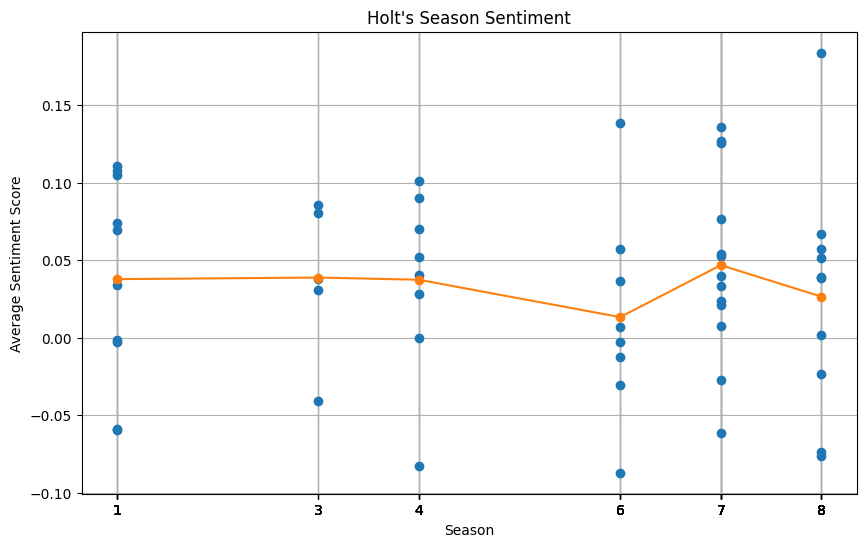

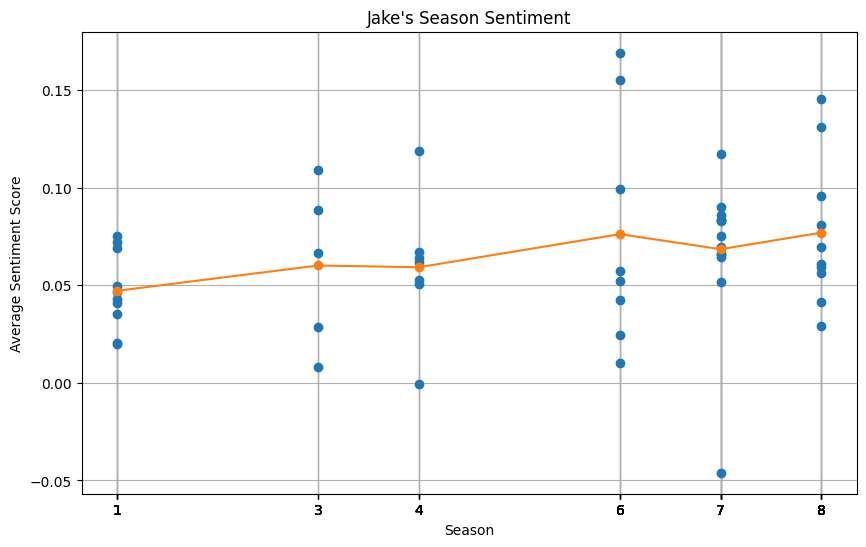

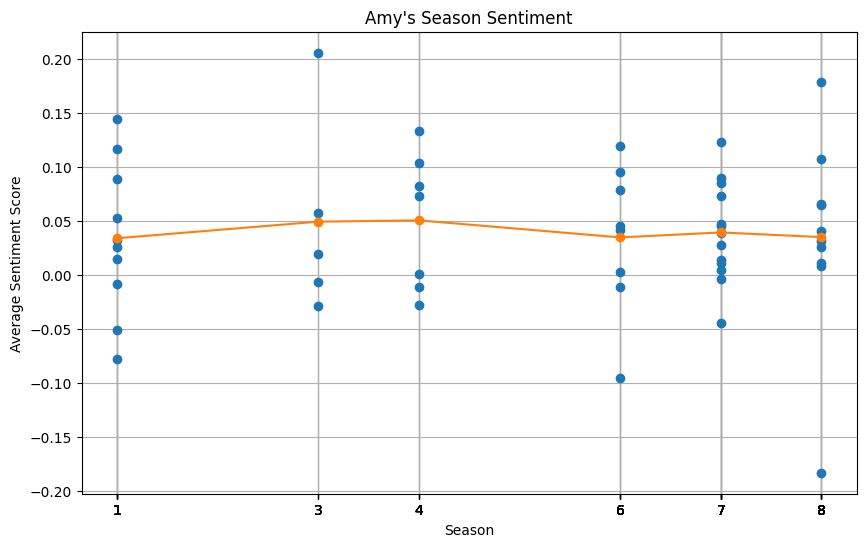

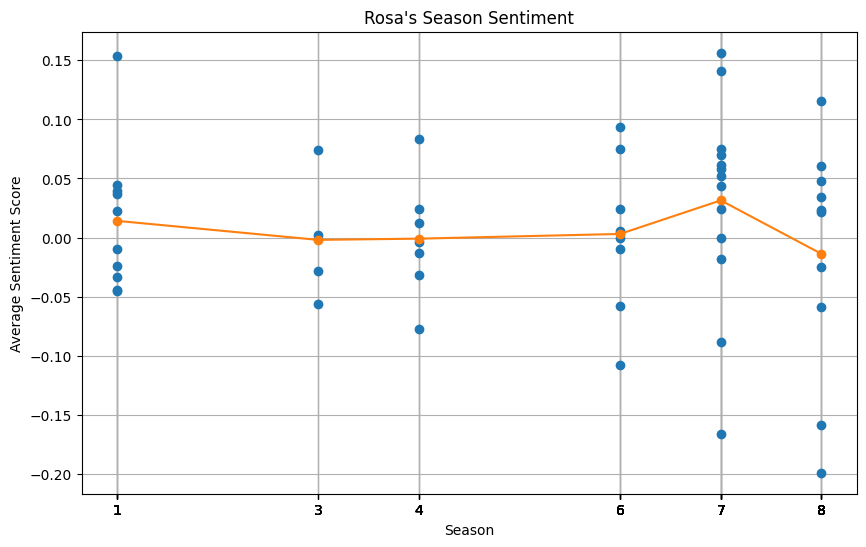

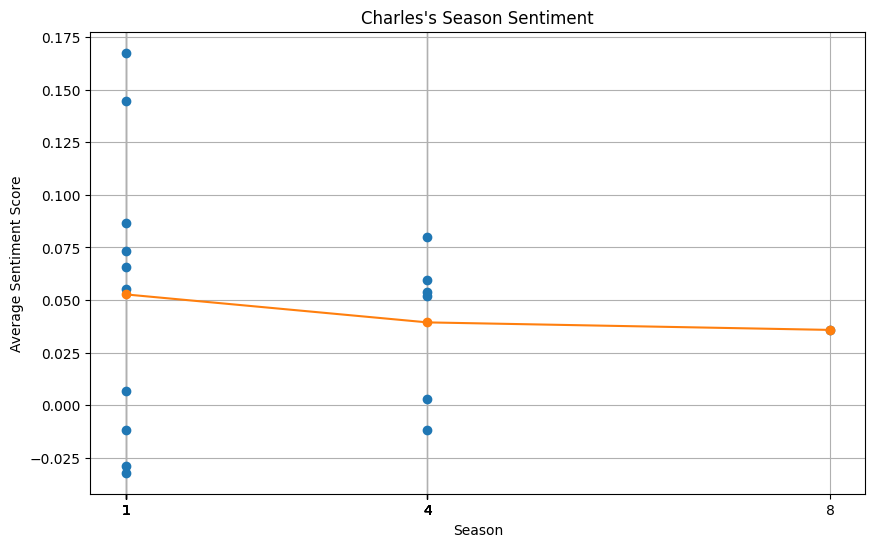

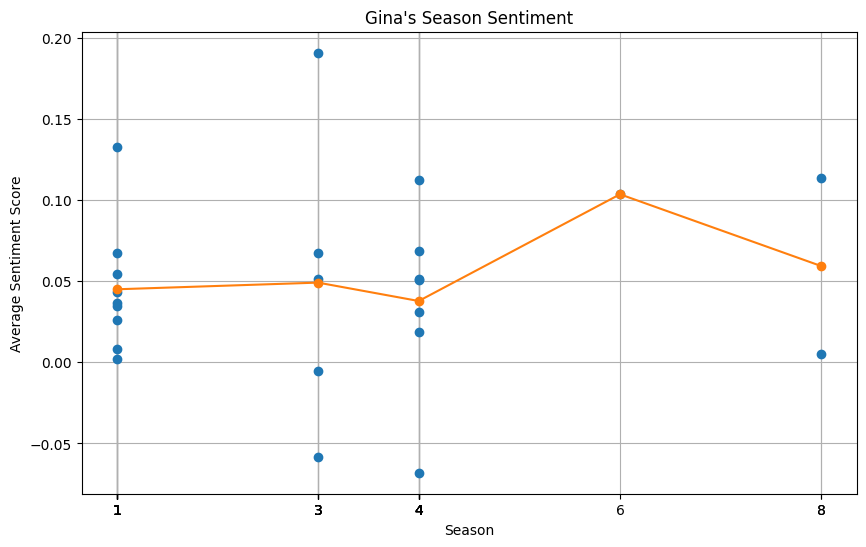

In [ ]:
# Plot season sentiment for each character

# Plot season sentiment for Holt
plt.figure(figsize=(10, 6))
plt.plot(Holt_lines['season'], Holt_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(Holt_sentiment_stats.index, Holt_sentiment_stats['mean'], marker='o')
plt.title("Holt's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(Holt_lines['season'])
plt.grid(True)
plt.show()


# Plot season sentiment for Jake
plt.figure(figsize=(10, 6))
plt.plot(Jake_lines['season'], Jake_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(Jake_sentiment_stats.index, Jake_sentiment_stats['mean'], marker='o')
plt.title("Jake's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(Jake_lines['season'])
plt.grid(True)
plt.show()

# Plot season sentiment for Amy
plt.figure(figsize=(10, 6))
plt.plot(Amy_lines['season'], Amy_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(Amy_sentiment_stats.index, Amy_sentiment_stats['mean'], marker='o')
plt.title("Amy's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(Amy_lines['season'])
plt.grid(True)
plt.show()

# Plot season sentiment for Rosa
plt.figure(figsize=(10, 6))
plt.plot(Rosa_lines['season'], Rosa_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(Rosa_sentiment_stats.index, Rosa_sentiment_stats['mean'], marker='o')
plt.title("Rosa's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(Rosa_lines['season'])
plt.grid(True)
plt.show()

# Plot season sentiment for Charles
plt.figure(figsize=(10, 6))
plt.plot(Charles_lines['season'], Charles_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(Charles_sentiment_stats.index, Charles_sentiment_stats['mean'], marker='o')
plt.title("Charles's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(Charles_lines['season'])
plt.grid(True)
plt.show()

# Plot season sentiment for Charles
plt.figure(figsize=(10, 6))
plt.plot(Gina_lines['season'], Gina_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(Gina_sentiment_stats.index, Gina_sentiment_stats['mean'], marker='o')
plt.title("Gina's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(Gina_lines['season'])
plt.grid(True)
plt.show()


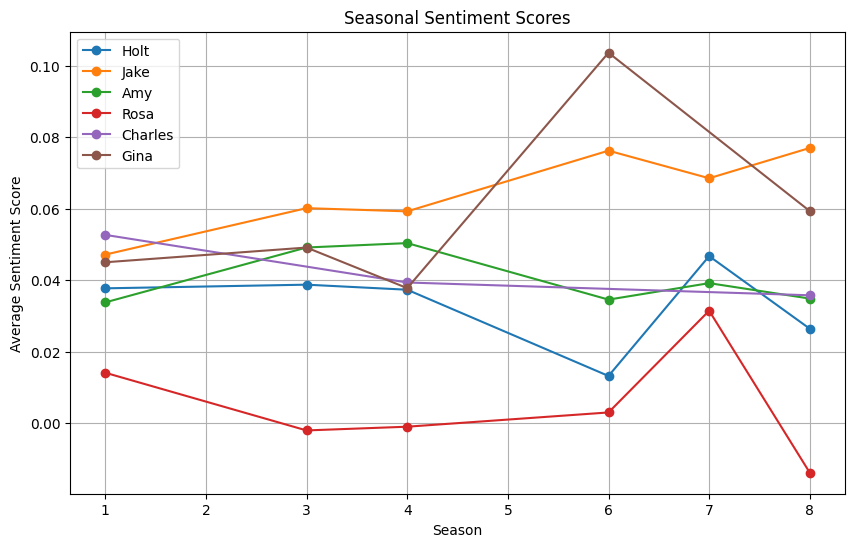

In [ ]:
# Plot mean sentiment scores
plt.figure(figsize=(10, 6))

plt.plot(Holt_sentiment_stats.index, Holt_sentiment_stats['mean'], marker='o', label='Holt')
plt.plot(Jake_sentiment_stats.index, Jake_sentiment_stats['mean'], marker='o', label='Jake')
plt.plot(Amy_sentiment_stats.index, Amy_sentiment_stats['mean'], marker='o', label='Amy')
plt.plot(Rosa_sentiment_stats.index, Rosa_sentiment_stats['mean'], marker='o', label='Rosa')
plt.plot(Charles_sentiment_stats.index, Charles_sentiment_stats['mean'], marker='o', label='Charles')
plt.plot(Gina_sentiment_stats.index, Gina_sentiment_stats['mean'], marker='o', label='Gina')

plt.title('Seasonal Sentiment Scores')
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(np.arange(1, 9))
plt.legend()
plt.grid(True)
plt.show()


##TFIDF

In [ ]:
cleaned_df = b99_script.copy()
cleaned_df['dialogue'] = cleaned_df['dialogue'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
cleaned_df

,season,episode,title,character,dialogue
0,1,1,Pilot,Jake,This job is eating me alive I cant breathe an...
1,1,1,Pilot,Amy,Hey What are you doing weirdo
2,1,1,Pilot,Jake,Im doing the best speech from Donnie Brasco O...
3,1,1,Pilot,Amy,Get it together man Okay
4,1,1,Pilot,Amy,So the store was hit about two hours ago They...
...,...,...,...,...,...
17524,8,10,The Last Day (2),Rosa,Me too
17525,8,10,The Last Day (2),Gina,As am I
17526,8,10,The Last Day (2),Jake,Thats right Terry
17527,8,10,The Last Day (2),Terry,What I say is


In [ ]:

groupedEpisode = cleaned_df.groupby(['season', 'episode'])['dialogue'].agg(lambda x: ' '.join(x))
groupedEpisode = groupedEpisode.reset_index();
groupedEpisode['preprocessed_dialogue'] = groupedEpisode['dialogue'].apply(lambda x: preprocess_dialog(x))
groupedEpisode = groupedEpisode[['season', 'episode', 'dialogue', 'preprocessed_dialogue']]
groupedEpisode.drop(index=25, inplace=True)

groupedEpisode

,season,episode,dialogue,preprocessed_dialogue
0,1,1,This job is eating me alive I cant breathe an...,job eating alive cant breathe anymore spent ye...
1,1,2,Ah Captain Youre at my desk Just what I wanna...,ah captain youre desk wanna see first thing mo...
2,1,3,For the last time the best cop movies in orde...,last time best cop movies order training day l...
3,1,4,Im so glad we could finally do this I know K...,glad could finally kylie says youre always stu...
4,1,5,Hey you guys see the dude I brought in today T...,hey guys see dude brought today drug dealer ye...
5,1,6,Sorry sarge Ugh Halloween is the worst Everyon...,sorry sarge ugh halloween worst everyones drun...
6,1,7,Knocks Hey Capn got a second Its Captain Wh...,knocks hey capn got second captain say capn li...
7,1,8,Careful You only get one shot at this Peralt...,careful one shot peralta worry saw first minut...
8,1,9,Oh this is amazing This is so amazing Everyth...,amazing amazing everything amazing talking vir...
9,1,10,Happy Turkey Day Yes Right out of the gate Wha...,happy turkey day yes right gate whats going pl...


In [ ]:
# Function to calculate sentiment polarity for a given text
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment analysis to each episode's dialogue
groupedEpisode['sentiment_polarity'] = groupedEpisode['preprocessed_dialogue'].apply(get_sentiment)

groupedEpisode

,season,episode,dialogue,preprocessed_dialogue,sentiment_polarity
0,1,1,This job is eating me alive I cant breathe an...,job eating alive cant breathe anymore spent ye...,0.170505
1,1,2,Ah Captain Youre at my desk Just what I wanna...,ah captain youre desk wanna see first thing mo...,0.012049
2,1,3,For the last time the best cop movies in orde...,last time best cop movies order training day l...,0.104296
3,1,4,Im so glad we could finally do this I know K...,glad could finally kylie says youre always stu...,0.008313
4,1,5,Hey you guys see the dude I brought in today T...,hey guys see dude brought today drug dealer ye...,0.094537
5,1,6,Sorry sarge Ugh Halloween is the worst Everyon...,sorry sarge ugh halloween worst everyones drun...,0.100131
6,1,7,Knocks Hey Capn got a second Its Captain Wh...,knocks hey capn got second captain say capn li...,0.105649
7,1,8,Careful You only get one shot at this Peralt...,careful one shot peralta worry saw first minut...,0.137885
8,1,9,Oh this is amazing This is so amazing Everyth...,amazing amazing everything amazing talking vir...,0.088000
9,1,10,Happy Turkey Day Yes Right out of the gate Wha...,happy turkey day yes right gate whats going pl...,0.144461


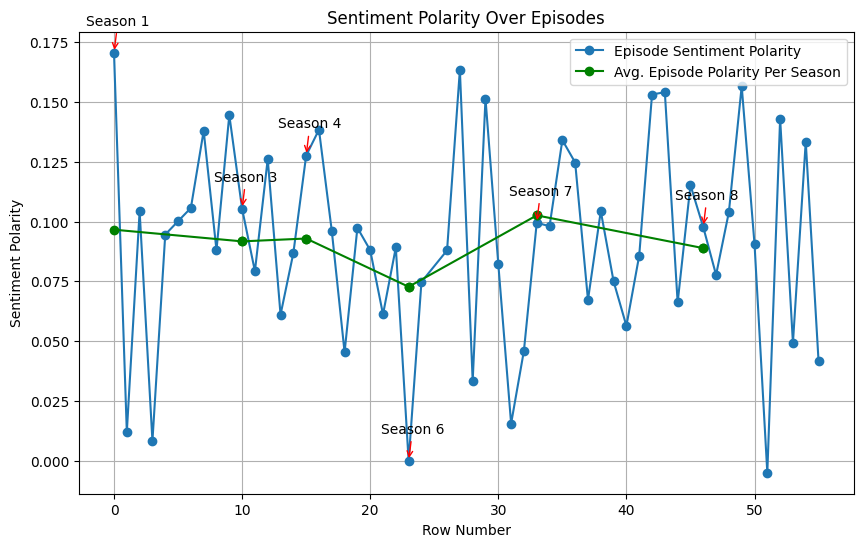

In [ ]:
# Calculate average sentiment polarity for each season
season_avg_sentiment = groupedEpisode.groupby('season')['sentiment_polarity'].mean()

# Find indices of the beginning episode of each season
season_beginning_indices = groupedEpisode.groupby('season').head(1).index

# Find indices where season changes occur
season_change_indices = groupedEpisode.index[groupedEpisode['season'].diff() != 0].tolist()

# Plot sentiment polarity over rows
plt.figure(figsize=(10, 6))
plt.plot(groupedEpisode.index, groupedEpisode['sentiment_polarity'], marker='o', linestyle='-', label='Episode Sentiment Polarity')

# Annotate season change points
for index in season_change_indices:
    plt.annotate(f'Season {groupedEpisode.at[index, "season"]}', xy=(index, groupedEpisode.at[index, 'sentiment_polarity']),
                 xytext=(-20, 20), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='r'))


# Plot average sentiment polarity for each season
for i in range(len(season_beginning_indices) - 1):
    start_index = season_beginning_indices[i]
    end_index = season_beginning_indices[i+1]
    plt.plot([start_index, end_index], [season_avg_sentiment.iloc[i], season_avg_sentiment.iloc[i+1]], marker='o', linestyle='-', color='g')



# Plot the last average sentiment point
plt.plot(season_beginning_indices[-1], season_avg_sentiment.iloc[-1], marker='o', linestyle='-', color='g', label = 'Avg. Episode Polarity Per Season')

plt.title('Sentiment Polarity Over Episodes')
plt.xlabel('Row Number')
plt.ylabel('Sentiment Polarity')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
groupedEpisode['tokenized_dialogue'] = groupedEpisode['preprocessed_dialogue'].apply(lambda x: word_tokenize(x))

word_lemma = WordNetLemmatizer()
#lemmatize word to root form(ex. cars to car, things to thing)
def lemma(txt):
    l_txt = [word_lemma.lemmatize(w) for w in txt]
    return l_txt

#lemmatize verbs to root form(ex. running to run, making to make)
def lemma_as_verb(txt):
    l_txt = [word_lemma.lemmatize(w, pos='v') for w in txt]  # Assume every word is a verb
    return l_txt


groupedEpisode['tokenized_dialogue'] = groupedEpisode['tokenized_dialogue'].apply(lambda x:lemma(x))
groupedEpisode['tokenized_dialogue'] = groupedEpisode['tokenized_dialogue'].apply(lambda x:lemma_as_verb(x))
groupedEpisode.head()

,season,episode,dialogue,preprocessed_dialogue,sentiment_polarity,tokenized_dialogue
0,1,1,This job is eating me alive I cant breathe an...,job eating alive cant breathe anymore spent ye...,0.170505,"[job, eat, alive, cant, breathe, anymore, spen..."
1,1,2,Ah Captain Youre at my desk Just what I wanna...,ah captain youre desk wanna see first thing mo...,0.012049,"[ah, captain, youre, desk, wan, na, see, first..."
2,1,3,For the last time the best cop movies in orde...,last time best cop movies order training day l...,0.104296,"[last, time, best, cop, movie, order, train, d..."
3,1,4,Im so glad we could finally do this I know K...,glad could finally kylie says youre always stu...,0.008313,"[glad, could, finally, kylie, say, youre, alwa..."
4,1,5,Hey you guys see the dude I brought in today T...,hey guys see dude brought today drug dealer ye...,0.094537,"[hey, guy, see, dude, bring, today, drug, deal..."


In [ ]:
tfidf_vectorizer = TfidfVectorizer()

groupedEpisode['preprocessed_dialogue'] = groupedEpisode['tokenized_dialogue'].apply(lambda x: ' '.join(x))

tfidf_weights = tfidf_vectorizer.fit_transform(groupedEpisode['preprocessed_dialogue'])

tfidf_df = pd.DataFrame(tfidf_weights.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


top_words_per_row = tfidf_df.apply(lambda row: row.nlargest(20).index.tolist(), axis=1)

top_words_and_scores_per_row = tfidf_df.apply(lambda row: [(word, row[word]) for word in row.nlargest(20).index], axis=1)

groupedEpisode['top_20_words'] = top_words_per_row

In [ ]:
# Filter DataFrame for Season 7, Episode 21
def plotTopWords(s, e):
  target = top_words_and_scores_per_row[(groupedEpisode['season'] == s) & (groupedEpisode['episode'] == e)].iloc[0]

  # Unpack words and scores
  words, scores = zip(*target)

  # Plot top words and their TF-IDF scores for Season 7, Episode 21
  plt.figure(figsize=(10, 6))
  plt.bar(words, scores)
  plt.title(f'Top 20 Words and Their TF-IDF Scores for Season {s}, Episode {e}')
  plt.xlabel('Words')
  plt.ylabel('TF-IDF Score')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

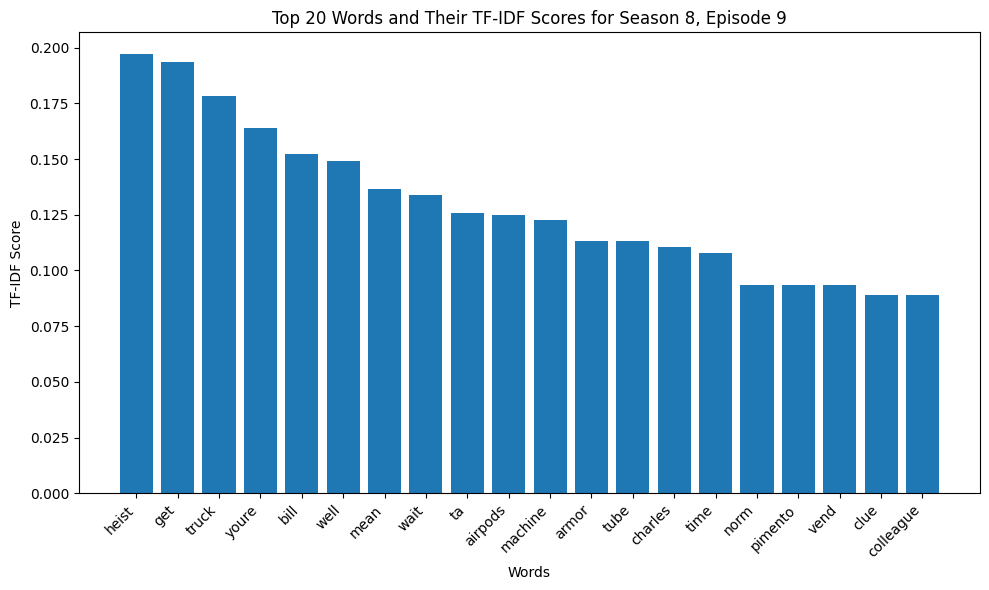

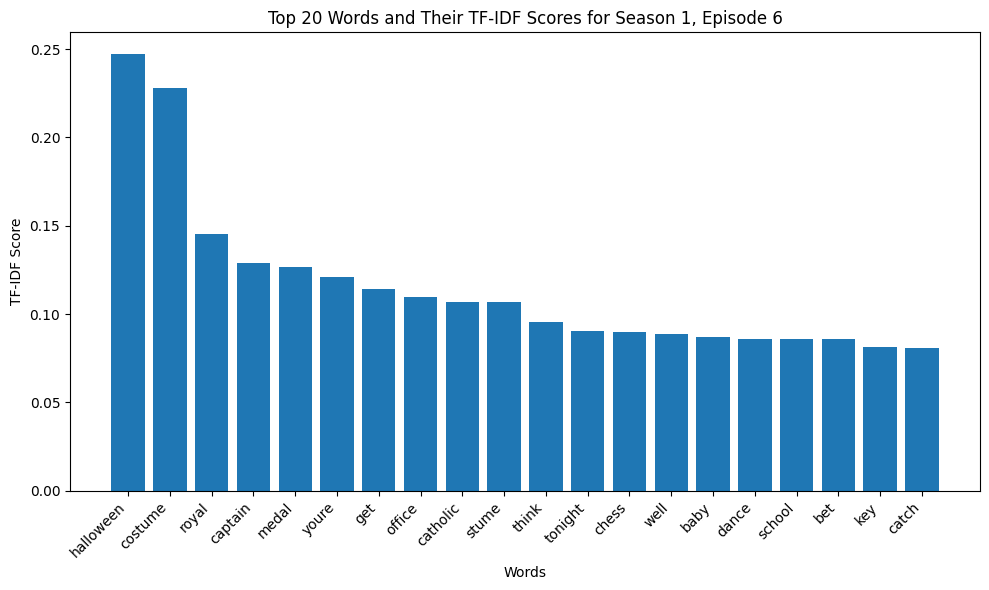

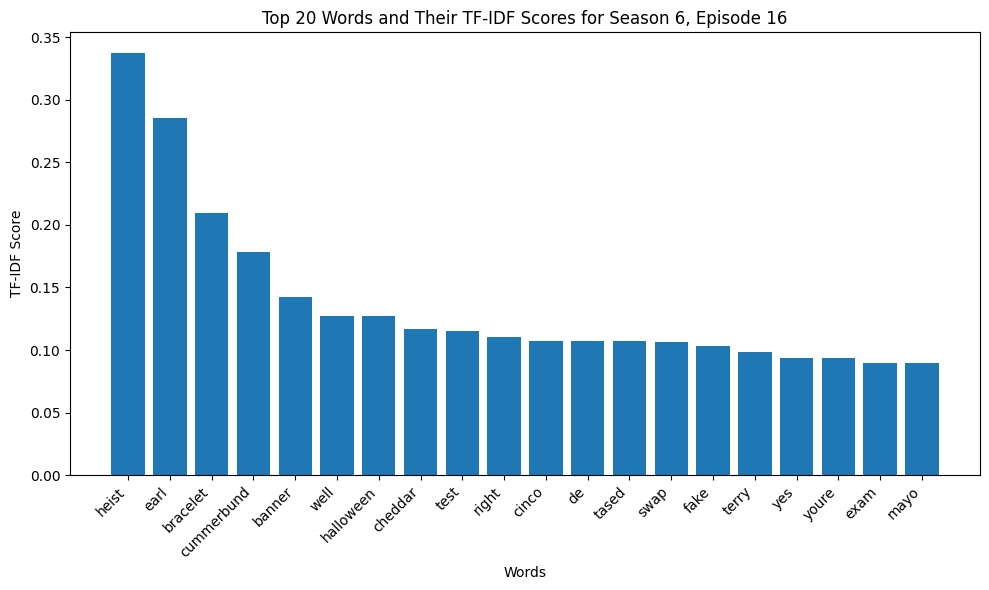

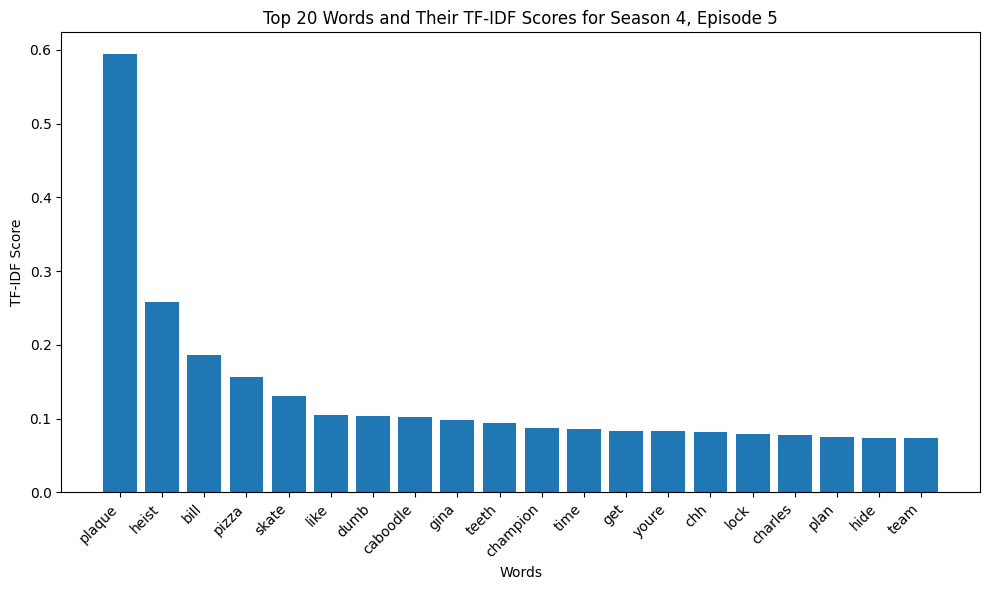

In [ ]:
plotTopWords(8, 9)
plotTopWords(1, 6)
plotTopWords(6, 16)
plotTopWords(4, 5)